In [3]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np
import itertools as it

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
get_ipython().magic(u'matplotlib inline')

all_scores = {}

datasets = {'B1AR_all':'2VT4'}#, 'B2AR_all':'2RH1'}

glide_ifp='xglide8'
crystal_ifp='xcrystal8'
w = [0,0,10,10,10,5,10,10,10,0.2,0,0,0]

for receptor in ['B2AR_all']:#datasets:#, s in datasets.items():
    
    os.system('mkdir -p /scratch/PI/rondror/docking_data/{}/scoring_output'.format(receptor))
        
    (xcrystals, xglides, ligs, structs) = load_data(receptor,
                                                    w=w,
                                                    require_fp=True,
                                                    glide_ifp=glide_ifp,
                                                    crystal_ifp=crystal_ifp,
                                                    load_docking=True)
    
    
    all_scores[receptor] = {}
    g = 27
    
    for i, s in enumerate(['4QKX']):#xcrystals.keys()):
        if i > 1: break
        
        all_scores[receptor][s] = {}
    
        filt_lig = sorted([l for l in ligs if l != s])

        all_scores[receptor][s][tuple(filt_lig)] = Scores(xglides, xcrystals, filt_lig, s, 25, gscore_weight=g)
        all_pair_scores = all_scores[receptor][s][tuple(filt_lig)].all_scores
        #final_rmsds = plot_final_rmsds(all_scores[receptor][s][tuple(filt_lig)], 'hi')
        
        with open('/scratch/PI/rondror/docking_data/{}/scoring_output/{}_struct.txt'.format(receptor, s), 'a') as output_f:
            output_f.write('# {} g={} {} {}\n'.format(w, g, glide_ifp, crystal_ifp))
            output_f.write(str(len(filt_lig)) + ':' + ','.join(filt_lig) + '\n' )    
            output_f.write(','.join([str(int(all_scores[receptor][s][tuple(filt_lig)].get_top_num(l, 1, glide=False))) for l in filt_lig]) + '\n' )
            
            for k in range(1,len(filt_lig)):
                print i, k
                for combo in it.combinations(filt_lig, k):
            #        #print combo
                    all_scores[receptor][s][combo] = Scores(xglides, xcrystals, list(combo), s, 25, 
                                                            gscore_weight=g, all_scores=all_pair_scores)
                    output_f.write(str(len(combo)) + ':' + ','.join(combo) + '\n' )    
                    output_f.write(','.join([str(int(all_scores[receptor][s][combo].get_top_num(l, 1, glide=False))) for l in combo]) + '\n' )
                    #break
        '''all_scores[receptor][s] = Scores(xglides, xcrystals, filt_lig, s, 25, gscore_weight=g)

        title = '{} docked to: {}. g={}'.format(receptor, s, g)
        final_rmsds = plot_final_rmsds(all_scores[receptor][s], title)
        plot_shared_interactions(all_scores[receptor][s], max_r=20, title=title)
        plot_docking_by_structure(filt_lig, s, xglides, n_list=[0,5,25,300], title=title, scores=all_scores[receptor][s])

        print s, 'performance:'
        print_table(all_scores[receptor][s])'''

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


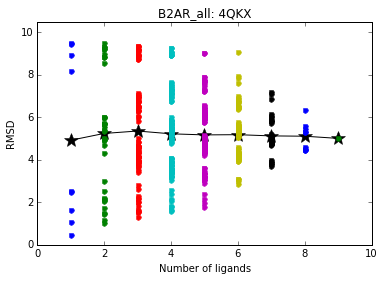

In [6]:
get_ipython().magic(u'matplotlib inline')

for receptor in all_scores:
    for s in all_scores[receptor]:
        tr = {}
        for combo, scores in all_scores[receptor][s].items():
            #print len(combo), np.mean([scores.get_top(l, 1, False) for l in combo])
            if len(combo) not in tr:
                tr[len(combo)] = []
            tr[len(combo)].append(np.mean([scores.get_top_rmsd(l, 1, False) for l in combo]))

        plt.plot([c for c, r in tr.items()], [np.mean(r) for c, r in tr.items()], '*-k', markersize=15)
        max_y = 0
        for combo_size, rmsds in tr.items():
            max_y = max(max(rmsds), max_y)
            #plt.plot([combo_size], [np.mean(rmsds)], '.k', markersize=20)
            plt.plot([combo_size]*len(rmsds), rmsds, '.', markersize=10)
            #break
        plt.title('{}: {}'.format(receptor, s))
        plt.xlabel('Number of ligands')
        plt.ylabel('RMSD')
        plt.axis([0,max(tr.keys())+1, 0, max_y+1])
        plt.show()

In [ ]:
print [xglides['2VT4']['2Y02'].poses[i].gscore for i in range(5)]

In [ ]:
sc = Scores(xglides, xcrystals, ['2VT4'], '2Y02', 25, gscore_weight=g)

In [ ]:
print sc.get_top('2VT4'ligands

In [4]:
print xcrystals['2VT4']['A:129(ILE)']

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [5]:
print xcrystals['2VT4']['A:203(THR)']

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.24449823  0.          0.          0.        ]


In [14]:
def parse_fp(fp, w):
    fp_dict = {}
    for i in fp.split(';'):
        fp_prod = np.multiply(w, [float(j) for j in i.split(',')[1:]])
        if any(fp_prod):
            fp_dict[i.split(',')[0]] = fp_prod
    return fp_dict
    #return {i.split(',')[0]:np.multiply(w, [float(j) for j in i.split(',')[1:]]) for i in fp.split(';')}

with open('/scratch/PI/rondror/docking_data/B1AR_all/ifp/xcrystal8/2Y02.fp', 'r') as f:
    for line in f:
        fp = parse_fp(line, w)
        line = line.strip().split(';')
        print len(line), len(fp)
        for aa in line:
            print aa
            print fp.get(aa.split(',')[0],'gone')

69 23
A:206(ALA),0,0,0,0,0,0,0,0,0,0,0,0.0466083339643,0.0637312330318
gone
A:216(PHE),0,0,0,0,0,0,0,0,0,0,0,0.397080638428,0.587223596371
gone
A:122(VAL),0,0,0,0,0,0,0,0,0,50.5303332564,17.961676356,5.04601343161,7.48029889498
[  0.           0.           0.           0.           0.           0.           0.
   0.           0.          10.10606665   0.           0.           0.        ]
A:332(GLY),0,0,0,0,0,0,0,0,0,0,0,0.103021438145,0.143065493963
gone
A:205(ARG),0,0,0,0,0,0,0,0,0,0,0,0.0628084096404,0.0844103070973
gone
A:306(PHE),0,0,0,0,0,2.37144563436,0.847030465867,0,0,51.2788288646,21.8803871252,5.45059968945,8.41508063631
[  0.           0.           0.           0.           0.          11.85722817
   8.47030466   0.           0.          10.25576577   0.           0.           0.        ]
A:107(TRP),0,0,0,0,0,0,0,0,0,0,0,0.154567638284,0.209681436181
gone
A:209(ILE),0,0,0,0,0,0,0,0,0,0,0,0.195743724316,0.28927844901
gone
A:121(ASP),0,1.88350571676,0,2.2,1.41951804602,0,0,0,